##### Find out if matrix D is following some random distribution or not

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# sys.path.append('/Users/lennartredl/Desktop/MachineLearningProjects/TheisLab_Mubind/mubind')


In [4]:
cd ~/workspace/theislab/mubind/docs/notebooks/single_cell

/mnt/c/Users/IgnacioIbarra/Dropbox/workspace/theislab/mubind/docs/notebooks/single_cell


/home/ilibarra/.conda/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/ilibarra/.conda/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
# changing directory remove if another filesystem


In [6]:
# load models
model_by_logdynamic = {}
for use_logdynamic in [False, True]:
    p = 'pancreas_multiome_use_logdynamic_%i.pth' % use_logdynamic
    # p = 'noack_2022_use_logdynamic_%i.pth' % use_logdynamic
    print(p)
    model_by_logdynamic[use_logdynamic] = torch.load(p)

pancreas_multiome_use_logdynamic_0.pth
pancreas_multiome_use_logdynamic_1.pth


In [7]:
model = model = model_by_logdynamic[1]

In [8]:
# for convenience
tsum = torch.sum
texp = torch.exp
tspa = torch.sparse_coo_tensor
tsmm = torch.sparse.mm
t = torch.transpose

# get the connectivity and weight matrix from the model
C = model.graph_module.conn_sparse
a_ind = C.indices()
D = model.graph_module.log_dynamic
D_tril = tspa(a_ind, D, C.shape) 
D_triu = tspa(a_ind, -D, C.shape)  
D = D_tril + torch.transpose(D_triu, 0, 1)

In [9]:
import mubind as mb

scramble = mb.tl.metric_scramble_comparison
normalized = mb.tl.normalized_alignment_score

scores_alignment_flat = scramble(C, D, normalized, 'flat', verbose=0)
scores_alignment_row = scramble(C, D, normalized, 'row', verbose=0)
scores_alignment_column = scramble(C, D, normalized, 'column', verbose=0)
original_score = normalized(C, D)


In [10]:
def hist(x, y, lab1, lab2, title,
         xlab='Normalized Alignment Score',
         ylab='Frequency'):
    plt.hist(x, bins=30, alpha=0.7, label=lab1)
    plt.axvline(y,
                color='r',
                linestyle='dashed',
                linewidth=2,
                label=lab2)
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.legend()


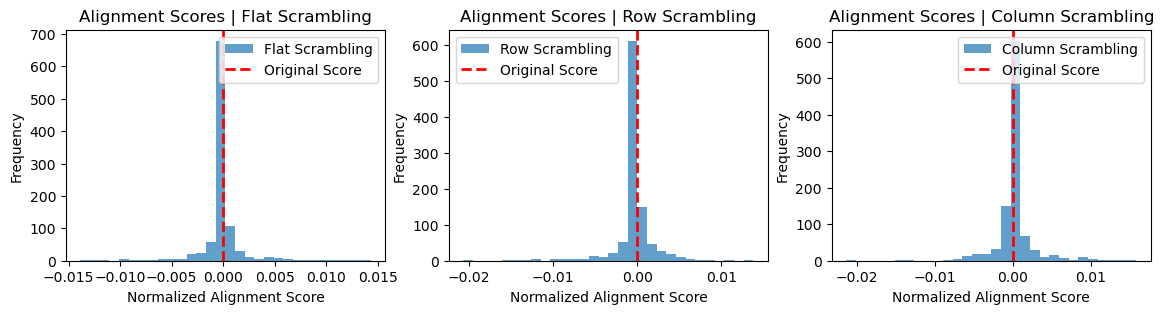

In [11]:
plt.figure(figsize=(14, 3))
# flat scrambling
plt.subplot(1, 3, 1)
hist(scores_alignment_flat,
     original_score,
     'Flat Scrambling',
     'Original Score',
     'Alignment Scores | Flat Scrambling')
# row scrambling
plt.subplot(1, 3, 2)
hist(scores_alignment_row,
     original_score,
     'Row Scrambling',
     'Original Score',
     'Alignment Scores | Row Scrambling')
# column scrambling
plt.subplot(1, 3, 3)
hist(scores_alignment_column,
     original_score,
     'Column Scrambling',
     'Original Score',
     'Alignment Scores | Column Scrambling')
plt.show()

In [12]:

positives_alignment_flat = scramble(C, C, normalized, 'flat', verbose=0)
positives_alignment_row = scramble(C, C, normalized, 'row', verbose=0)
positives_alignment_column = scramble(C, C, normalized, 'column', verbose=0)
positives_original_score = normalized(C, C)

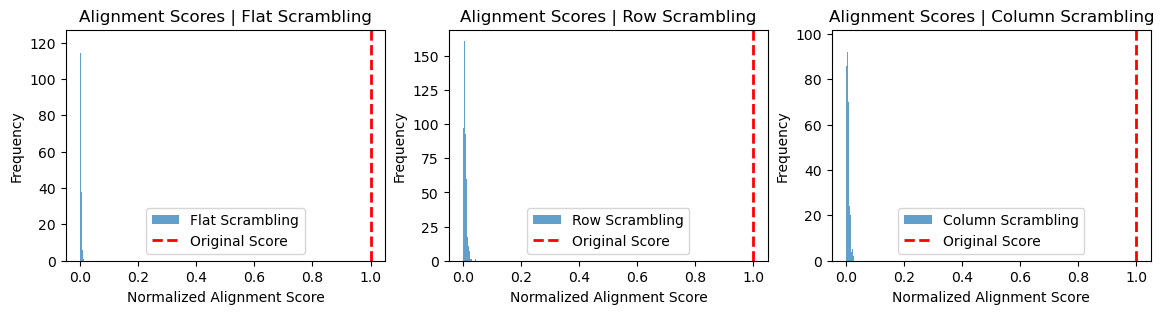

In [13]:
plt.figure(figsize=(14, 3))
plt.subplot(1, 3, 1)

hist(positives_alignment_flat,
     positives_original_score,
     'Flat Scrambling',
     'Original Score',
     'Alignment Scores | Flat Scrambling')

plt.subplot(1, 3, 2)
hist(positives_alignment_row,
     positives_original_score,
     'Row Scrambling',
     'Original Score',
     'Alignment Scores | Row Scrambling')

plt.subplot(1, 3, 3)
hist(positives_alignment_column,
     positives_original_score,
     'Column Scrambling',
     'Original Score',
     'Alignment Scores | Column Scrambling')


#### Understand the contribution of the filters

In [14]:
print(model.get_log_activities().shape)

torch.Size([1, 288, 496])


In [15]:
# Y_com = B @ A @ (G * D)

In [16]:

# considering  graph-indepppendent effects
# indices, contributions, max_eig = compute_contributions(B.T @ A.T, C * D)


In [18]:
A = model.get_log_activities()
sum_A = A.abs().sum(axis=1).detach().numpy()
A = A.squeeze(0)
print(A.shape)

torch.Size([288, 496])


In [19]:
# this function assesses the contributions of A on the graph
indices, contributions, max_eig = mb.tl.compute_contributions(A, C * D)

contributions_normalized = torch.abs(contributions) / max_eig
contributions_df = pd.DataFrame(contributions_normalized.detach(), columns=['index'])
print("Summary statistics of the normalized contributions: \n")
contributions_df.describe()

Summary statistics of the normalized contributions: 



,index
count,288.000000
mean,0.573716
std,0.135060
min,0.284841
25%,0.481841
50%,0.577438
75%,0.667456
max,0.856258


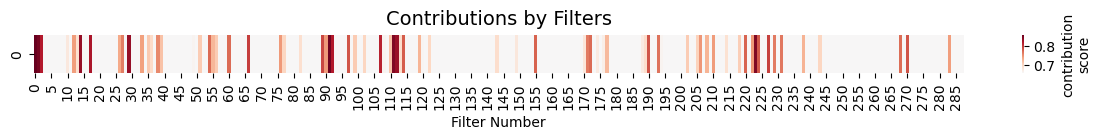

In [20]:
mb.pl.filter_contrib_heatmap(contributions_normalized)

Percentage of non-zero entries of the filter matrix A: 100.0 %
(288,) (288,)


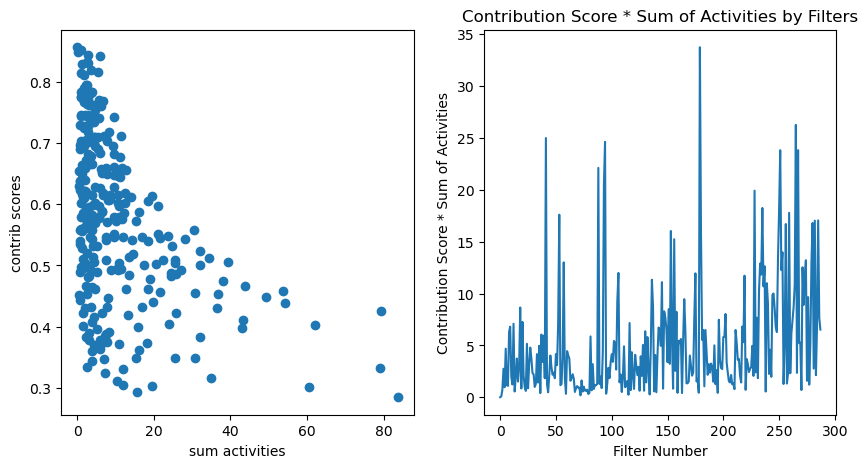

In [22]:
from matplotlib.pyplot import rcParams
rcParams['figure.dpi'] = 100
plt.figure(figsize=(10, 5))


print(f"Percentage of non-zero entries of the filter matrix A: {100 * torch.sum(A != 0).item() / A.numel()} %")

mb.pl.filter_contrib_simple(contributions_normalized, A)

In [23]:
# normalize the data, and look at summary stats
sum_A_norm = sum_A / np.max(sum_A)
sum_A_df = pd.DataFrame(sum_A.T, columns=['sum_A'])
sum_A_df.describe()

,sum_A
count,496.000000
mean,5.945687
std,8.916358
min,1.714348
25%,2.374378
50%,3.196430
75%,5.918693
max,94.113457


In [24]:
contrib_arr = contributions_normalized.unsqueeze(dim=0).detach().numpy()
sum_A = A.abs().sum(axis=1).detach().numpy()
contrib = contrib_arr[0]

contrib_times_activities = contrib * sum_A
contrib_times_activities_norm = contrib_times_activities / np.max(contrib_times_activities)
contrib_times_activities_df = pd.DataFrame(contrib_times_activities, columns=['contribution_times_activities'])
contrib_times_activities_df.describe()

,contribution_times_activities
count,288.000000
mean,5.070957
std,5.403158
min,0.001415
25%,1.399696
50%,3.163624
75%,6.499539
max,33.760483


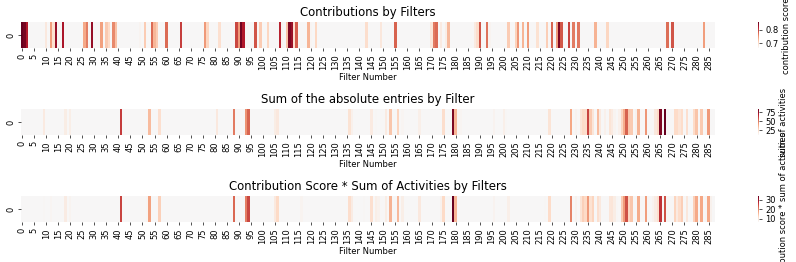

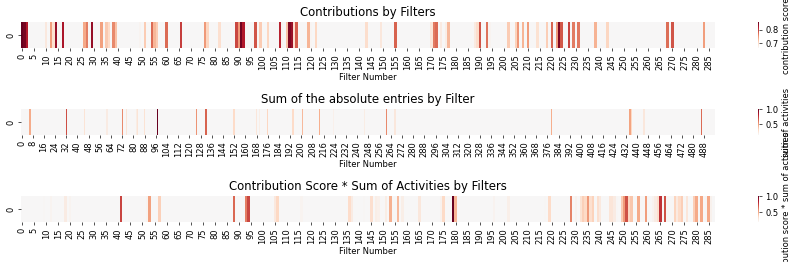

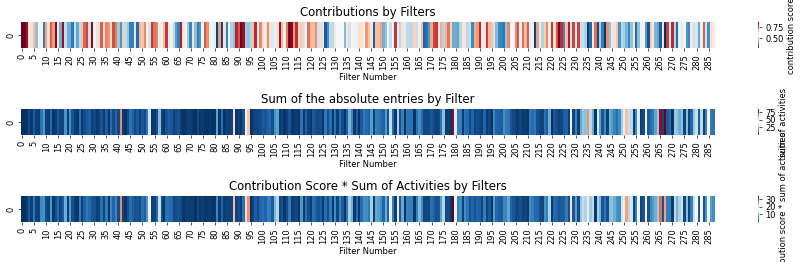

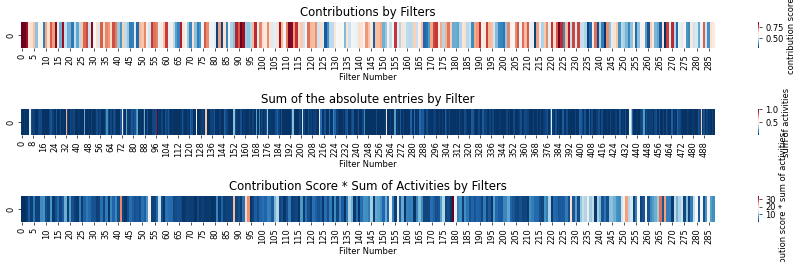

In [25]:
from matplotlib.pyplot import rcParams
rcParams['figure.dpi'] = 60

# unsqueeze the data to make it compatible with the heatmap function
sum_A_norm = sum_A_norm.reshape(1,-1)
contrib_times_activities = contrib_times_activities.reshape(1,-1)


# only plotting filters, that are within the top 25% of the maximum contribution score
mb.pl.contrib_heatmaps(contributions_normalized,
                       sum_A.reshape(1, -1),
                       contrib_times_activities,
                       (0.66, 11.85, 6.49),
                       (0.66, 11.85, 6.49)) # vmin values come from the describe() functions

# plotting top 25% of filters normalized
mb.pl.contrib_heatmaps(contributions_normalized,
                       sum_A_norm,
                       contrib_times_activities_norm.reshape(1,-1),
                       vmins=(0.66, 0.14, 0.19),
                       centers=(0.66, 0.14, 0.19)) # vmin values come from the describe() functions

# plotting all filter
mb.pl.contrib_heatmaps(contributions_normalized,
                       sum_A.reshape(1, -1),
                       contrib_times_activities)

# plotting all filters normalized
mb.pl.contrib_heatmaps(contributions_normalized,
                       sum_A_norm,
                       contrib_times_activities)